In [80]:
from collections import defaultdict
# import data processing modules
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import the statistical learning modules 
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
# import the deep learning modules
import torch
import torch.nn as nn
# import file path constants
from constants import DATA_PATH, OUTPUT_PATH, AMR_UTI_PATH

In [12]:
# load the features, resistance (target), prescription (human prediction) dataset into dataframes
features_df = pd.read_csv(f"{AMR_UTI_PATH}/all_uti_features.csv", index_col=0)
resistance_df = pd.read_csv(f"{AMR_UTI_PATH}/all_uti_resist_labels.csv", index_col=0)
prescription_df = pd.read_csv(f"{AMR_UTI_PATH}/all_prescriptions.csv", index_col=0)

In [33]:
print(f"features_df.shape: {features_df.shape}")
features_df.head()

features_df.shape: (116902, 790)


,demographics - age,demographics - is_white,demographics - is_veteran,micro - prev resistance LVX 14,micro - prev resistance AMP 14,micro - prev resistance CFZ 14,micro - prev resistance NIT 14,micro - prev resistance GEN 14,micro - prev resistance SXT 14,micro - prev resistance TET 14,...,selected micro - colonization pressure NIT 90 - overall,selected micro - colonization pressure OXA 90 - overall,selected micro - colonization pressure PEN 90 - overall,selected micro - colonization pressure SAM 90 - overall,selected micro - colonization pressure SXT 90 - overall,selected micro - colonization pressure TET 90 - overall,selected micro - colonization pressure TZP 90 - overall,selected micro - colonization pressure VAN 90 - overall,is_train,uncomplicated
example_id,,,,,,,,,,,,,,,,,,,,,
0,54,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.24,0.56,0.49,0.38,0.26,0.37,0.06,0.13,0,0
1,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.19,0.78,0.83,0.33,0.20,0.35,0.18,0.13,1,0
2,89,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.21,0.66,0.51,0.50,0.25,0.37,0.05,0.12,1,0
3,49,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.23,0.47,0.50,0.25,0.26,0.35,0.06,0.12,1,0
4,21,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.24,0.50,0.49,0.33,0.25,0.37,0.05,0.10,1,1


In [40]:
# filter the features for the uncomplicated UTI features
uncomplicated_index = features_df["uncomplicated"] == 1
uncomplicated_features_df = features_df[uncomplicated_index]
# separate into train and test sets 
train_index = uncomplicated_features_df["is_train"] == 1
train_features, test_features = uncomplicated_features_df[train_index], uncomplicated_features_df[~train_index]
train_features = train_features.drop(columns=["is_train", "uncomplicated"])
test_features = test_features.drop(columns=["is_train", "uncomplicated"])
# view the dimensions 
print(f"Train features shape: {train_features.shape}")
print(f"Test features shape: {test_features.shape}")

Train features shape: (11865, 788)
Test features shape: (3941, 788)


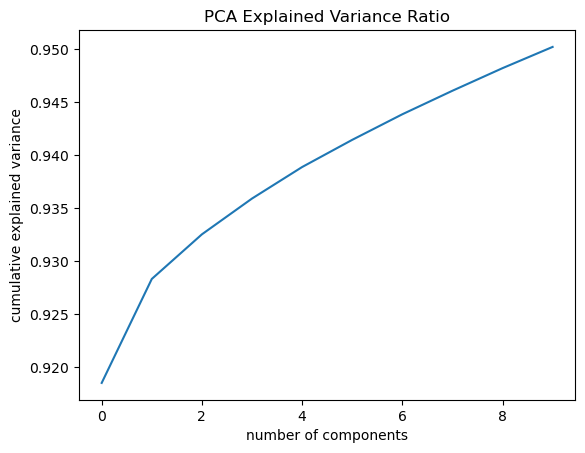

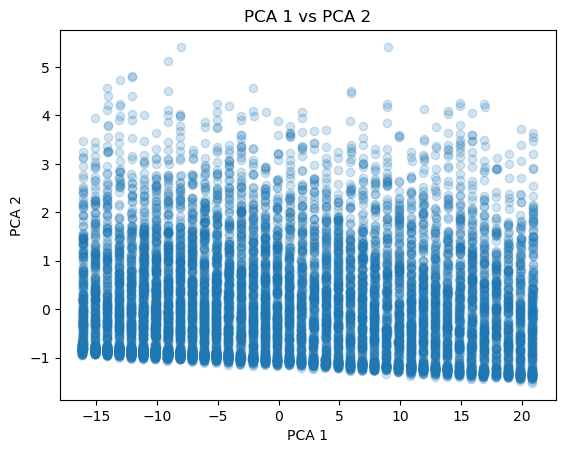

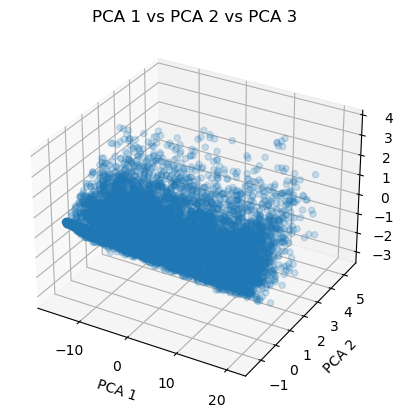

In [26]:
# apply PCA to the features dataframe and visualize the explained variance ratio
pca = PCA(n_components=10)
pca.fit(train_features)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.title("PCA Explained Variance Ratio")
plt.show()
# visualize the first three principal components
train_features_pca = pca.transform(train_features)
# plot the first two principal components
plt.scatter(train_features_pca[:, 0], train_features_pca[:, 1], alpha=0.2)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title("PCA 1 vs PCA 2")
plt.show()
# plot the first three principal components
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train_features_pca[:, 0], train_features_pca[:, 1], train_features_pca[:, 2], alpha=0.2)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.title("PCA 1 vs PCA 2 vs PCA 3")
plt.show()

In [36]:
uncomplicated_features_df.head()

,demographics - age,demographics - is_white,demographics - is_veteran,micro - prev resistance LVX 14,micro - prev resistance AMP 14,micro - prev resistance CFZ 14,micro - prev resistance NIT 14,micro - prev resistance GEN 14,micro - prev resistance SXT 14,micro - prev resistance TET 14,...,selected micro - colonization pressure NIT 90 - overall,selected micro - colonization pressure OXA 90 - overall,selected micro - colonization pressure PEN 90 - overall,selected micro - colonization pressure SAM 90 - overall,selected micro - colonization pressure SXT 90 - overall,selected micro - colonization pressure TET 90 - overall,selected micro - colonization pressure TZP 90 - overall,selected micro - colonization pressure VAN 90 - overall,is_train,uncomplicated
example_id,,,,,,,,,,,,,,,,,,,,,
4,21,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.24,0.50,0.49,0.33,0.25,0.37,0.05,0.10,1,1
31,19,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.22,0.43,0.42,0.38,0.25,0.35,0.05,0.10,0,1
34,36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.19,0.58,0.57,0.67,0.24,0.36,0.05,0.09,1,1
36,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.24,0.42,0.43,0.37,0.26,0.35,0.06,0.11,0,1
48,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.19,0.68,0.69,0.50,0.22,0.32,0.09,0.09,1,1


In [39]:
resistance_df.head()

,NIT,SXT,CIP,LVX,is_train,uncomplicated
example_id,,,,,,
0,0.0,0.0,0.0,0.0,0,0
1,0.0,0.0,0.0,0.0,1,0
2,0.0,0.0,1.0,1.0,1,0
3,0.0,0.0,0.0,0.0,1,0
4,0.0,0.0,0.0,0.0,1,1


In [54]:
# separate into train and test label sets
uncomp_train_label = resistance_df[uncomplicated_index & train_index].drop(columns=["is_train", "uncomplicated"])
uncomp_test_label = resistance_df[uncomplicated_index & ~train_index].drop(columns=["is_train", "uncomplicated"])
uncomp_test_label.head()

,NIT,SXT,CIP,LVX
example_id,,,,
31,0.0,0.0,0.0,0.0
36,0.0,0.0,0.0,0.0
55,0.0,1.0,1.0,1.0
71,0.0,0.0,0.0,0.0
86,0.0,0.0,0.0,0.0


In [59]:
uncomp_train_label.values.shape

(11865, 4)

In [61]:
train_features.values.shape

(11865, 788)

In [93]:
# train feedforward network classifier to predict resistances from features
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define the hyper-parameters 
input_size = train_features.shape[1]
hidden_size = 1000
num_classes = 4
num_epochs = 40
batch_size = 64
learning_rate = 0.001

# data loader 
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_features.values).float(), torch.from_numpy(uncomp_train_label.values).float())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_features.values).float(), torch.from_numpy(uncomp_test_label.values).float())
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# define the feedforward network class
class Feedforward(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Feedforward, self).__init__()
        # define the layers
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size) 
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # define the forward pass
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out

# initialize the feedforward network
model = Feedforward(input_size, hidden_size, num_classes).to(device)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (features, labels) in enumerate(train_loader):  
        # move tensors to the configured device
        features = features.to(device)
        labels = labels.to(device)
        
        # forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print training statistics 
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')

# test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for features, labels in test_loader:
        # move tensors to the configured device
        features = features.to(device)
        labels = labels.to(device)
        
        # forward pass
        outputs = model(features)
        predicted = torch.round(torch.sigmoid(outputs))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # compute the correct based on the class 
    correct_class = 0
    print("\n----------------------------\nAccuracy of the network by class:")
    for i in range(4):
        correct_class += (predicted[:, i] == labels[:, i]).sum().item()
        # print the accuracy based on the class, using the class label 
        print(f'{uncomp_train_label.columns[i]}: {100 * (predicted[:, i] == labels[:, i]).sum().item() / labels.size(0):.4f}%')

Epoch [1/40], Step [100/186], Loss: 0.3463
Epoch [2/40], Step [100/186], Loss: 0.3137
Epoch [3/40], Step [100/186], Loss: 0.3004
Epoch [4/40], Step [100/186], Loss: 0.2227
Epoch [5/40], Step [100/186], Loss: 0.2751
Epoch [6/40], Step [100/186], Loss: 0.2928
Epoch [7/40], Step [100/186], Loss: 0.3032
Epoch [8/40], Step [100/186], Loss: 0.2508
Epoch [9/40], Step [100/186], Loss: 0.2105
Epoch [10/40], Step [100/186], Loss: 0.2625
Epoch [11/40], Step [100/186], Loss: 0.1611
Epoch [12/40], Step [100/186], Loss: 0.3011
Epoch [13/40], Step [100/186], Loss: 0.1947
Epoch [14/40], Step [100/186], Loss: 0.2703
Epoch [15/40], Step [100/186], Loss: 0.2064
Epoch [16/40], Step [100/186], Loss: 0.2529
Epoch [17/40], Step [100/186], Loss: 0.2051
Epoch [18/40], Step [100/186], Loss: 0.2921
Epoch [19/40], Step [100/186], Loss: 0.1576
Epoch [20/40], Step [100/186], Loss: 0.2278
Epoch [21/40], Step [100/186], Loss: 0.2318
Epoch [22/40], Step [100/186], Loss: 0.1585
Epoch [23/40], Step [100/186], Loss: 0.16

In [91]:
# compute the frequency of clinicians prescribing antibiotics for uncomplicated UTIs correctly
test_prescriptions = prescription_df[prescription_df["is_train"] == 0].drop(columns=["is_train"])
num_prescribed = defaultdict(int)
num_correct = defaultdict(int)
for i in range(len(test_prescriptions)):
    prescribed = test_prescriptions.iloc[i].values
    num_prescribed[prescribed[0]] += 1
    if uncomp_test_label.iloc[i][prescribed].values == 0:
        num_correct[prescribed[0]] += 1
print("Prescription Performance:")
for prescription in num_prescribed:
    print(f"{prescription}: {num_correct[prescription] / num_prescribed[prescription]:.4f} (total: {num_prescribed[prescription]})")

Prescription Performance:
NIT: 0.8888 (total: 1358)
SXT: 0.8087 (total: 1260)
CIP: 0.9431 (total: 1282)
LVX: 0.8780 (total: 41)
